In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Function to generate random feature set with given parameters
def F_set(low, high, N, theta):
    """
    Generates random feature set based on specified parameters.

    Args:
    - low (float): Lower bound for random values.
    - high (float): Upper bound for random values.
    - N (int): Number of data points.
    - theta (numpy.ndarray): Array of angles.

    Returns:
    - numpy.ndarray: Random feature set.
    """
    rho_0 = np.random.uniform(low, high, N)
    F = np.column_stack((rho_0 * np.cos(theta)))

    return F

In [3]:
# Function to create feature set based on given parameters
def make_feature(N0, N1, flavour, POut):
    """
    Generates feature set based on specified parameters.

    Args:
    - N0 (int): Number of points in Class 0.
    - N1 (int): Number of points in Class 1.
    - flavour (str): Flavor of the feature set.
    - POut (float): Percentage of outliers.

    Returns:
    - numpy.ndarray: Feature set.
    """
    N0_Out = round(N0 * POut)
    N1_Out = round(N1 * POut)
    N0_effective = N0 - N0_Out
    N1_effective = (N0 + N1) - (N0_Out + N1_Out + N0_effective)

    theta_N0_outliers = np.random.uniform(0, 2 * np.pi, N0_Out)
    theta_N1_outliers = np.random.uniform(0, 2 * np.pi, N1_Out)
    theta_N0 = np.random.uniform(0, 2 * np.pi, N0_effective)
    theta_N1 = np.random.uniform(0, 2 * np.pi, N1_effective)

    outlier_low = 1
    outlier_high = 50

    if flavour == 'VS':
        class_0_low = 0
        class_0_high = 1
        class_1_low = 1
        class_1_high = 2
    elif flavour == 'S':
        class_0_low = 0
        class_0_high = 1.25
        class_1_low = 0.75
        class_1_high = 2
    elif flavour == 'W':
        class_0_low = 0
        class_0_high = 1.5
        class_1_low = 0.5
        class_1_high = 2
    elif flavour == 'VW':
        class_0_low = 0
        class_0_high = 1.75
        class_1_low = 0.25
        class_1_high = 2
    elif flavour == 'I':
        return np.random.normal(0, 1, (N0 + N1, 1)).T

    class_0 = F_set(class_0_low, class_0_high, N0_effective, theta_N0)
    class_1 = F_set(class_1_low, class_1_high, N1_effective, theta_N1)
    F = np.concatenate((class_0, class_1), axis=1)

    if N0_Out > 0:
        class_0_outliers = F_set(outlier_low, outlier_high, N0_Out, theta_N0_outliers)
        F = np.concatenate((F, class_0_outliers), axis=1)

    if N1_Out > 0:
        class_1_outliers = F_set(outlier_low, outlier_high, N1_Out, theta_N1_outliers)
        F = np.concatenate((F, class_1_outliers), axis=1)

    return F

In [4]:
# Function to generate synthetic dataset
def synthetic_dataset(N0, N1, Rank, POut, filepath):
    """
    Generates a synthetic dataset based on specified parameters and saves it to a file.

    Args:
    - N0 (int): Number of points in Class 0.
    - N1 (int): Number of points in Class 1.
    - Rank (list): List of flavors.
    - POut (float): Percentage of outliers.
    - filepath (str): Path to save the dataset file.
    """
    D = np.hstack((np.zeros(N0), np.ones(N1)))
    D = D.reshape(-1, 1)

    header_set = []
    flavour_map = {'VS': 'Very Strong', 'S': 'Strong', 'W': 'Weak', 'VW': 'Very Weak', 'I': 'Irrelevant'}
    for i, flavour in enumerate(Rank):
        F = make_feature(N0, N1, flavour, POut)
        D = np.hstack((D, F.T))
        feature_header = 'Feature' + str(i + 1) + ' ' + flavour_map[flavour]
        header_set.append(feature_header)

    # Add header
    header = ['Label']
    header.extend(header_set)
    header = ','.join(header)

    np.random.shuffle(D)

    # Save data
    np.savetxt(filepath, D, header=header, comments='', delimiter=',', fmt='%f')


In [5]:
# Parameters
N0 = 50000  # Number of points in Class 0
N1 = 50000  # Number of points in Class 1
POut = 0.05  # Percentage of outliers
filepath = "data.csv"

Rank = ['VS', 'S', 'W', 'VW', 'I']  # Flavor ranks

In [6]:
# Generate synthetic dataset
synthetic_dataset(N0, N1, Rank, POut, filepath)

In [7]:
# Read the generated dataset
df = pd.read_csv('data.csv')

# Convert label column to integer type
df.Label = df.Label.astype(int)

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Display distribution of labels
print("\nDistribution of Label:")
print(df['Label'].value_counts())


Summary Statistics:
               Label  Feature1 Very Strong  Feature2 Strong  Feature3 Weak  \
count  100000.000000         100000.000000    100000.000000  100000.000000   
mean        0.500000             -0.006480        -0.009661      -0.004465   
std         0.500003              4.600054         4.750399       4.723130   
min         0.000000            -49.640772       -49.790773     -49.414591   
25%         0.000000             -0.557961        -0.599186      -0.591154   
50%         0.500000              0.000621        -0.000298       0.000576   
75%         1.000000              0.557349         0.599450       0.589544   
max         1.000000             49.838992        49.764897      49.738257   

       Feature4 Very Weak  Feature5 Irrelevant  
count       100000.000000        100000.000000  
mean            -0.013894             0.003517  
std              4.685101             1.000401  
min            -49.830135            -4.295387  
25%             -0.566420      

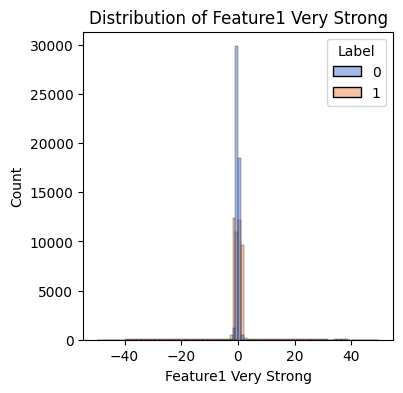

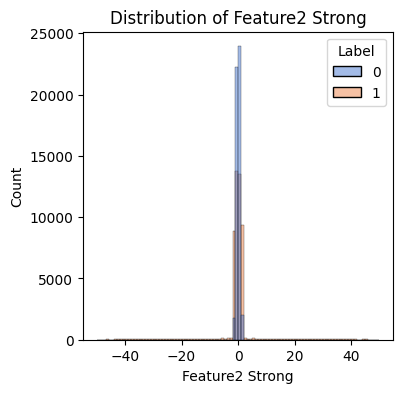

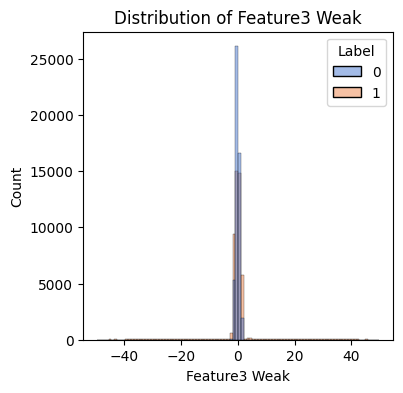

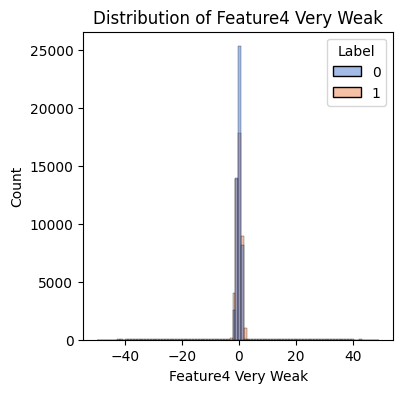

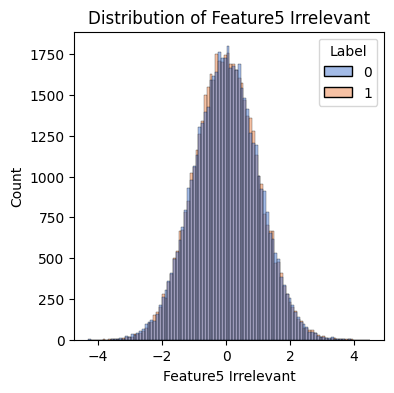

In [8]:
# Function to plot feature distribution
def plot_feature_distribution(df, features):
    """
    Plots the distribution of features.

    Args:
    - df (pandas.DataFrame): DataFrame containing the dataset.
    - features (list): List of feature names.
    """
    for feature in features:
        plt.figure(figsize=(4, 4))
        sns.histplot(data=df, x=feature, hue='Label', palette='muted', bins=100)
        plt.title(f'Distribution of {feature}')
        plt.show()

# List of features to plot
features = df.columns[1:]  # Exclude the label column
plot_feature_distribution(df, features)

In [9]:
# Split the data into features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = XGBClassifier(importance_type= 'gain')

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
# Calculate the baseline accuracy
most_frequent_class = y_train.mode()[0]
baseline_predictions = [most_frequent_class] * len(y_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f'Baseline Accuracy: {baseline_accuracy:.2f}')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Baseline Accuracy: 0.50
Accuracy: 0.86


                Feature  Importance
0  Feature1 Very Strong    0.576925
1       Feature2 Strong    0.244739
2         Feature3 Weak    0.105398
3    Feature4 Very Weak    0.049642
4   Feature5 Irrelevant    0.023296


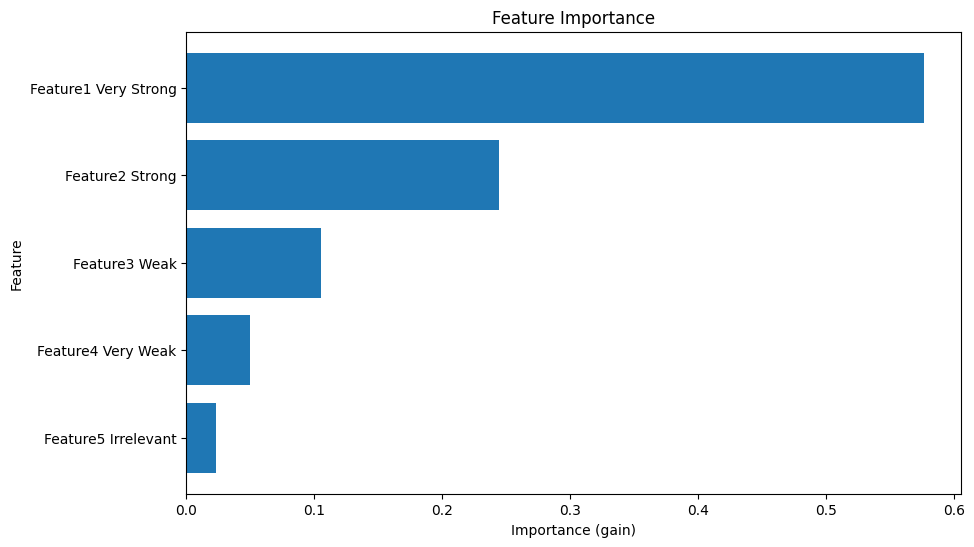

In [11]:
# Get feature importance
feature_importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance (gain)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()